# Pipeline Setup to Run the Model

## Set Up the Pipeline
A pipeline enables us to store all of the functions we have created in different stages and run only once. Each stage that is passed in won't run until the previous stage has been completed, which means the output of one stage is passed on to the next one.

We'll put the pipeline to use by employing a sample Yelp dataset. This will allow you to practice with a smaller set of reviews using similar data that you'll be working on for your client.

Open up a new notebook and run the usual setup.

In [ ]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.1'
spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

In [ ]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Yelp_NLP").getOrCreate()

Then load in the following dataset into a DataFrame by entering the following code.

In [ ]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://s3.amazonaws.com/dataviz-curriculum/day_2/yelp_reviews.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("yelp_reviews.csv"), sep=",", header=True)

# Show DataFrame
df.show()

Type the code to import all the functions that will be used in our NLP process, or pipeline, as follows:

In [ ]:
# Import functions
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer

Next, create a new column that uses the lengthfunction to create a future feature with the length of each row. This is similar to the tokenizerphase when we created our own udfto do the same thing. A udfcould still be used here, but PySpark makes it easier by supplying a ready-to-use function.

Type and run the following code.

In [ ]:
from pyspark.sql.functions import length
# Create a length column to be used as a future feature
data_df = df.withColumn('length', length(df['text']))
data_df.show()

Now we'll create all the transformations to be applied in our pipeline. Note that the StringIndexer encodes a string column to a column of table indexes. Here we are working with positive and negative game reviews, which will be converted to 0 and 1. This will form our labels, which we'll delve into in the ML unit. The label is what we're trying to predict: will the review's given text let us know if it was positive or negative?

Also note that we don't need to run all of these completely as we did before. By creating all the functions now, we can then use them all in the pipeline later.

Type and run the following code.

In [ ]:
# Create all the features to the data set
pos_neg_to_num = StringIndexer(inputCol='class',outputCol='label')
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')

We'll create a feature vector containing the output from the IDFModel (the last stage in the pipeline) and the length. This will combine all the raw features to train the ML model that we'll be using. Enter the code for this as follows:

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')

Now it's time to create our pipeline, the easiest step. We'll import the pipeline from pyspark.ml, and then store a list of the stages created earlier. It's important to list the stages in the order they need to be executed. As we mentioned before, the output from one stage will then be passed off to another stage.

Run the following code:

In [ ]:
# Create and run a data processing Pipeline
from pyspark.ml import Pipeline
data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])

Nice work! All the stages of the pipeline have been set up. You may have noticed that each individual step didn't need to be set up, which is the perk of setting up the pipeline! Now your data is ready to be run through the pipeline. Then we can run it through a machine learning model.

After our pipeline has been set up, we'll fit the outcome with our original DataFrame and transform it.

Type and run the following code:

In [ ]:
# Fit and transform the pipeline
cleaner = data_prep_pipeline.fit(data_df)
cleaned = cleaner.transform(data_df)

As you can see in the following image, our labels and features that we created early on in the process are numerical representations of positive and negative reviews. The features will be used in our model and predict whether a given review will be positive or negative. These features are the result of all the work we have been doing with the pipeline.

In [ ]:
# Show label and resulting features
cleaned.select(['lable', 'features']).show()

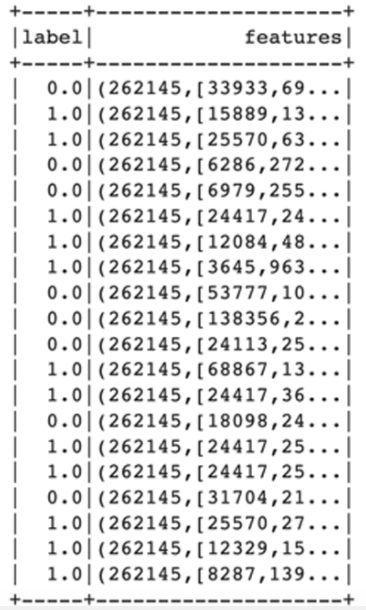

## IMPORTANT
You may not have seen the terms "fit," "predict," and "transform" before in this context. These terms will make more sense when we learn about machine learning:

Now let's run our ML model on the data. One of the basics of ML is that data gets broken into training data and testing data. Training data is the data that will be passed to our NLP model that will train our model to predict results. The testing data is used to test our predictions. We can do this with the randomSplit method, which takes in a list of the percent of data we want split into each group. Standard conventions use 70% with training and 30% with testing.

To split the data into a training set and a testing set, run the following code:

In [ ]:
# Break data down into a training set and a testing set
training, testing = cleaned.randomSplit([0.7, 0.3], 21)

The array supplied to randomSplit is the percentage of the data that will be broken into training and testing respectively. So 70% to training and 30% to testing. The second number supplied is called a seed. The seed number here, 21, is arbitrary. But as long as the same seed is used, the result will be the same each time. Using a seed number ensures reproducible results.

The ML model we'll use is Naive Bayes, which we'll import and then fit the model using the training dataset. Naive Bayes is a group of classifier algorithms based on Bayes' theorem. Bayes theorem provides a way to determine the probability of an event based on new conditions or information that might be related to the event.

Run the following code:

In [ ]:
from pyspark.ml.classification import NaiveBayes
# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

Once the model has been trained, we'll transform the model with our testing data. Run the following code, and then look at the results:



In [ ]:
# Transform the model with the testing data
test_results = predictor.transform(testing)
test_results.show(5)

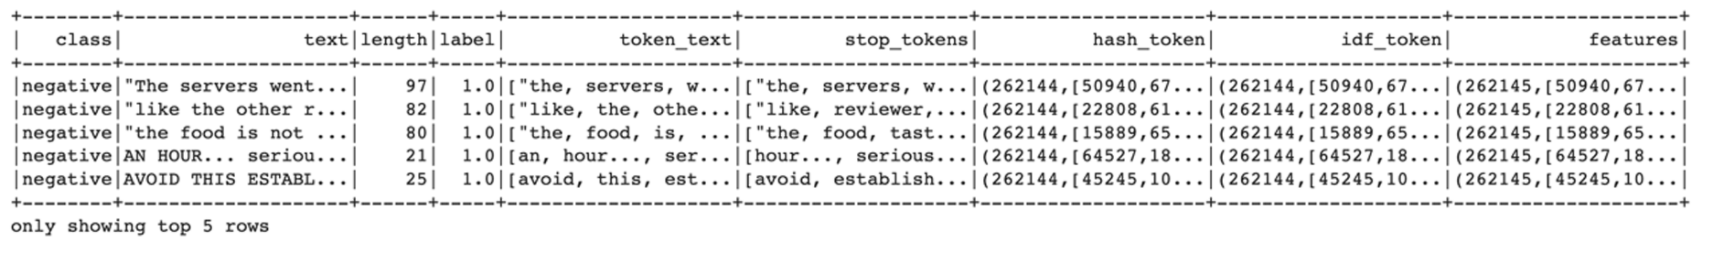

At first glance, it may seem like the model isn't showing us anything useful. From your output, scroll all the way to the right to view the prediction column:

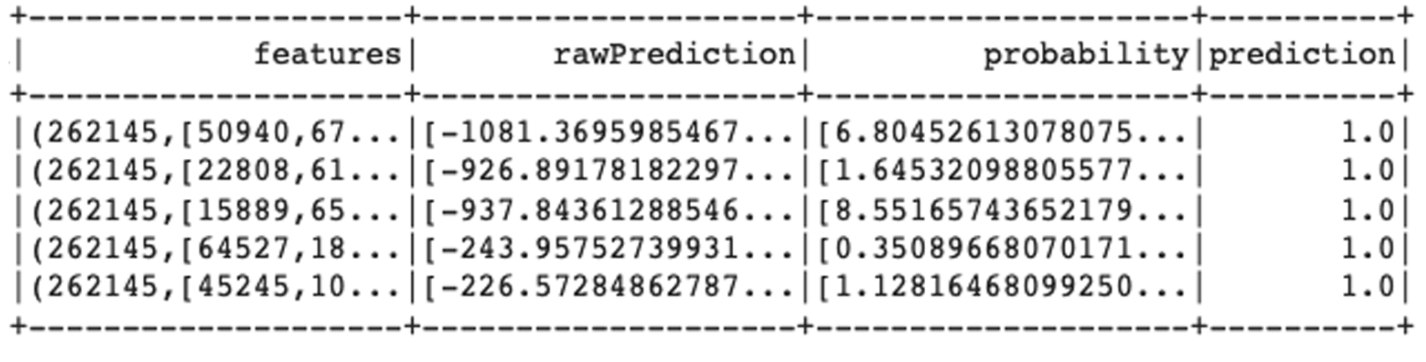

This prediction column will indicate with a 1.0 if the model thinks this review is negative and 0.0 if it thinks it's positive. Future data sets can now be run with this model and determine whether a review was positive or negative without having already supplied in the data.

How useful is this model? Should we just blindly trust that it will be right every time? There is one last step in the process to answer these questions.

It's often not enough to simply train and use a machine learning model for predictions without knowing how well the model performs at its prediction task. The last step is to import the BinaryClassificationEvaluator, which will display how accurate our model is in determining if a review with be positive or negative based solely on the text within a review.

The BinaryClassificationEvaluator uses two arguments, labelCol and rawPredictionCol. The labelCol takes the labels which were the result of using StringIndexer to convert our positive and negative strings to integers. The rawPredictionCol takes in numerical predictions from the output of running the Naive Bayes model.

The performance of a model can be measured based on the difference between its predicted values and actual values. This is what the BinaryClassificationEvaluator does. We will dive more into accuracy, precision, and sensitivity when we get to Machine Learning. Run the following code:

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

acc_eval = BinaryClassificationEvaluatior(labelCol='label', rawPredictionCol='prediction')
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting reviews was: %f" % acc)

The accuracy of the model isn't perfect, but it's not too low either: 0.700298. Machine learning isn't a guarantee, and tweaking our models as well as the data used is part of the process. One of the ways to do this is to add more data; when you keep adding data, eventually you grow from your local storage to something much larger—thus leading to big data!